Parte di riconoscimento pezzi "buoni" tramite rete YOLO

In [ ]:
#importo yolo YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 16623, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 16623 (delta 57), reused 65 (delta 29), pack-reused 16522
Receiving objects: 100% (16623/16623), 15.15 MiB | 24.46 MiB/s, done.
Resolving deltas: 100% (11410/11410), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.3/760.3 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
#Creazione cartella per le immagini di inferenza
!mkdir ../img

In [ ]:
#Parte di valutazione
%cd /content/yolov5/
!python detect.py --weights best.pt --img 1024 --conf 0.5 --source ../img --hide-conf --hide-label

Livello 2 per determinare se il pezzo identificato come buono sia destro o sinistro

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

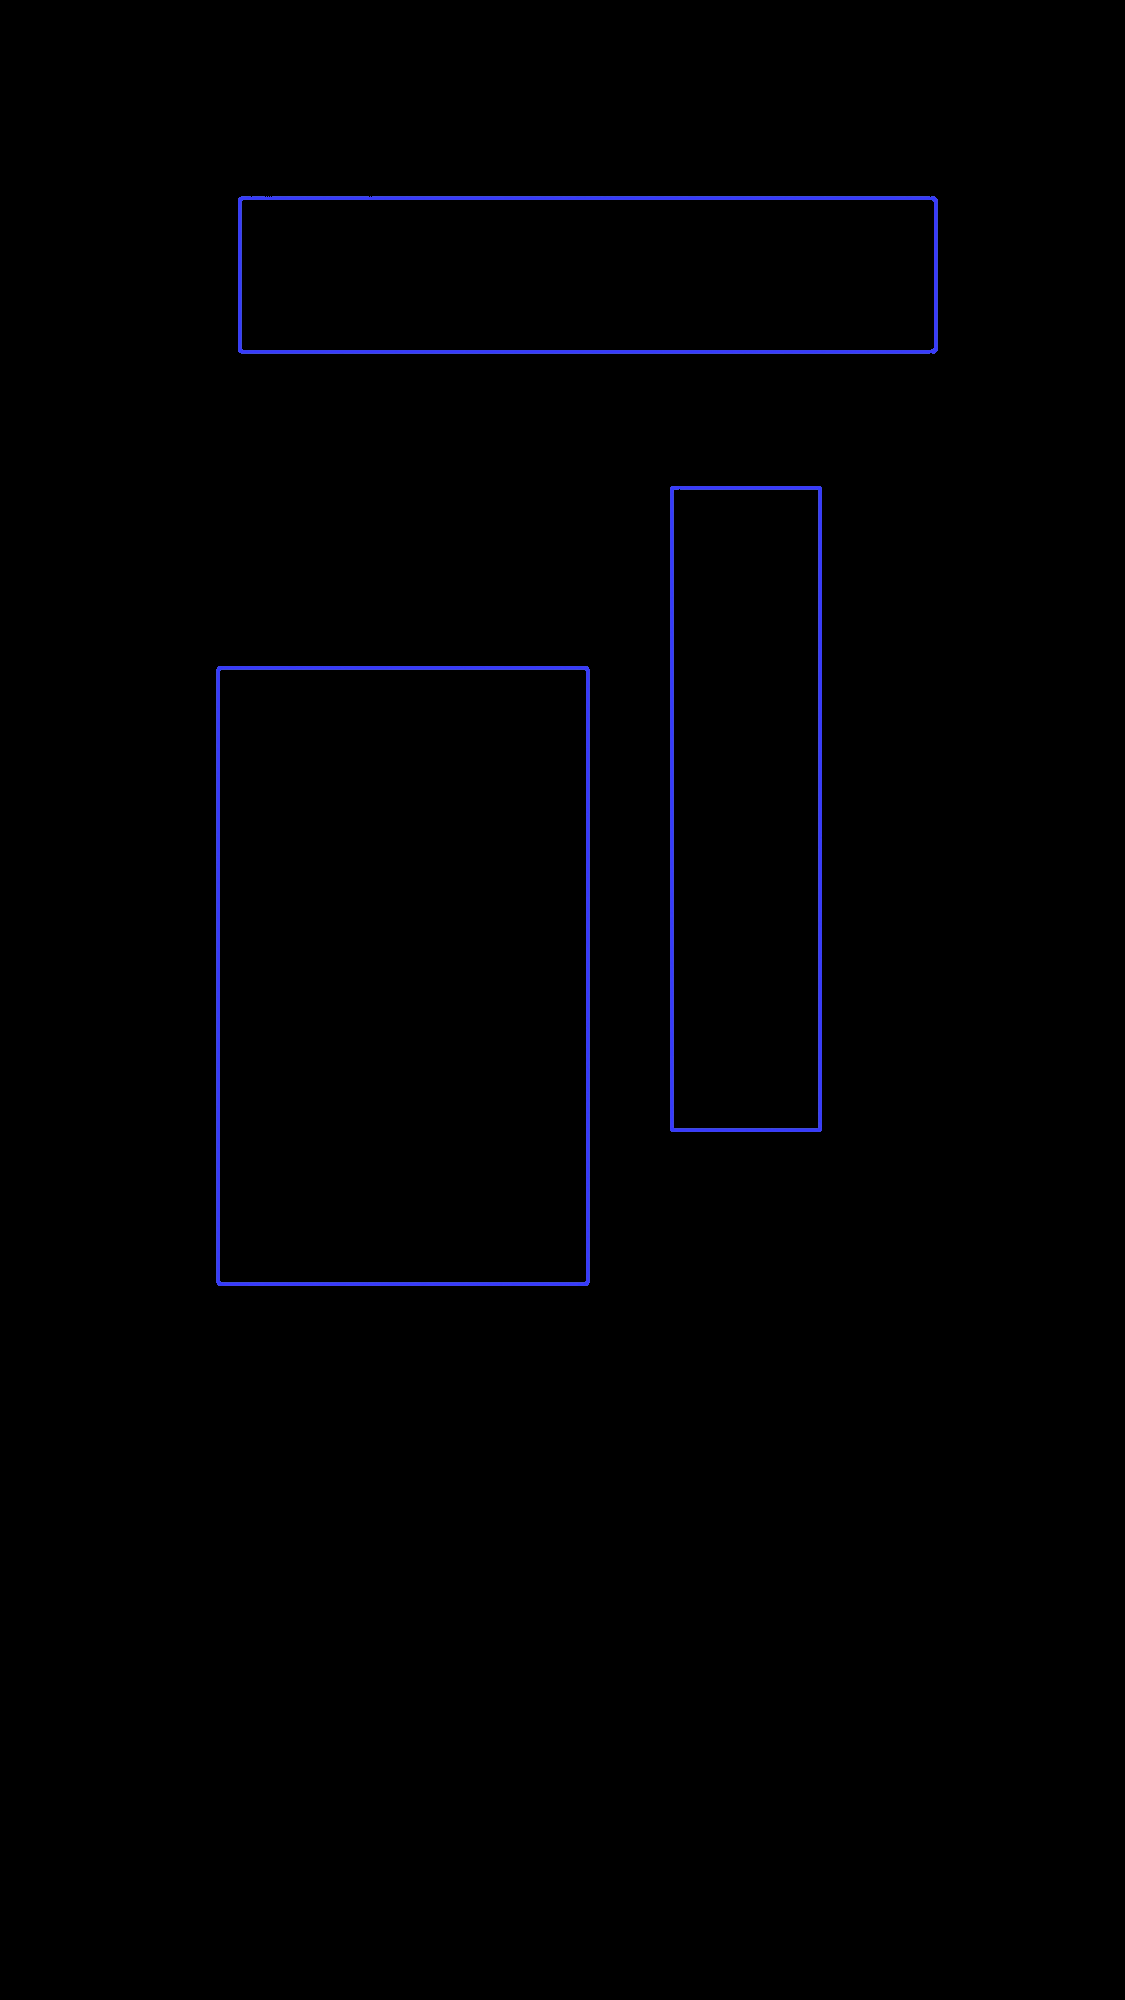

In [2]:
# Carica l'immagine
#Le immagini riconosciute tramite YOLO saranno rinominate "detected"
immagine = cv2.imread('/content/detected.jpeg')
copia=immagine.copy()

#Vado ad evidenziare i rettangoli precedentemente creati con YOLO in modo da poterne recuperare le coordinate

# Converti l'immagine in un array NumPy
array_immagine = np.array(immagine)
array2=np.array(copia)
# Crea una maschera per i pixel rossi
maschera = np.zeros_like(array_immagine, dtype=np.uint8)

h=immagine.shape[0]
w=immagine.shape[1]


for i in range(h):
  for j in range(w):
    if array_immagine[i,j][2] > 210 and array_immagine[i,j][0]<100:
      maschera[i,j]=array_immagine[i,j]




# Converte l'array NumPy in un'immagine
immagine_finale = cv2.cvtColor(maschera, cv2.COLOR_BGR2RGB)



# Mostra l'immagine filtrata
cv2_imshow(immagine_finale)





In [11]:
from math import atan2, cos, sin, sqrt, pi
import cv2 as cv

#Funzione per disegnare gli assi sull'immagine e capire quindi l'orientamento del pezzo
def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)


  angle = atan2(p[1] - q[1], p[0] - q[0]) # angolo in radianti
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))


  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)

  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)

  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
  ## [visualization1]

def getOrientation(pts, img):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]

  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)

  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]

  ## [visualization]
  # Draw the principal components
  cv.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)

  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
  ## [visualization]

  # Label with the rotation angle
  label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
  textbox = cv.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
  cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)

  return angle


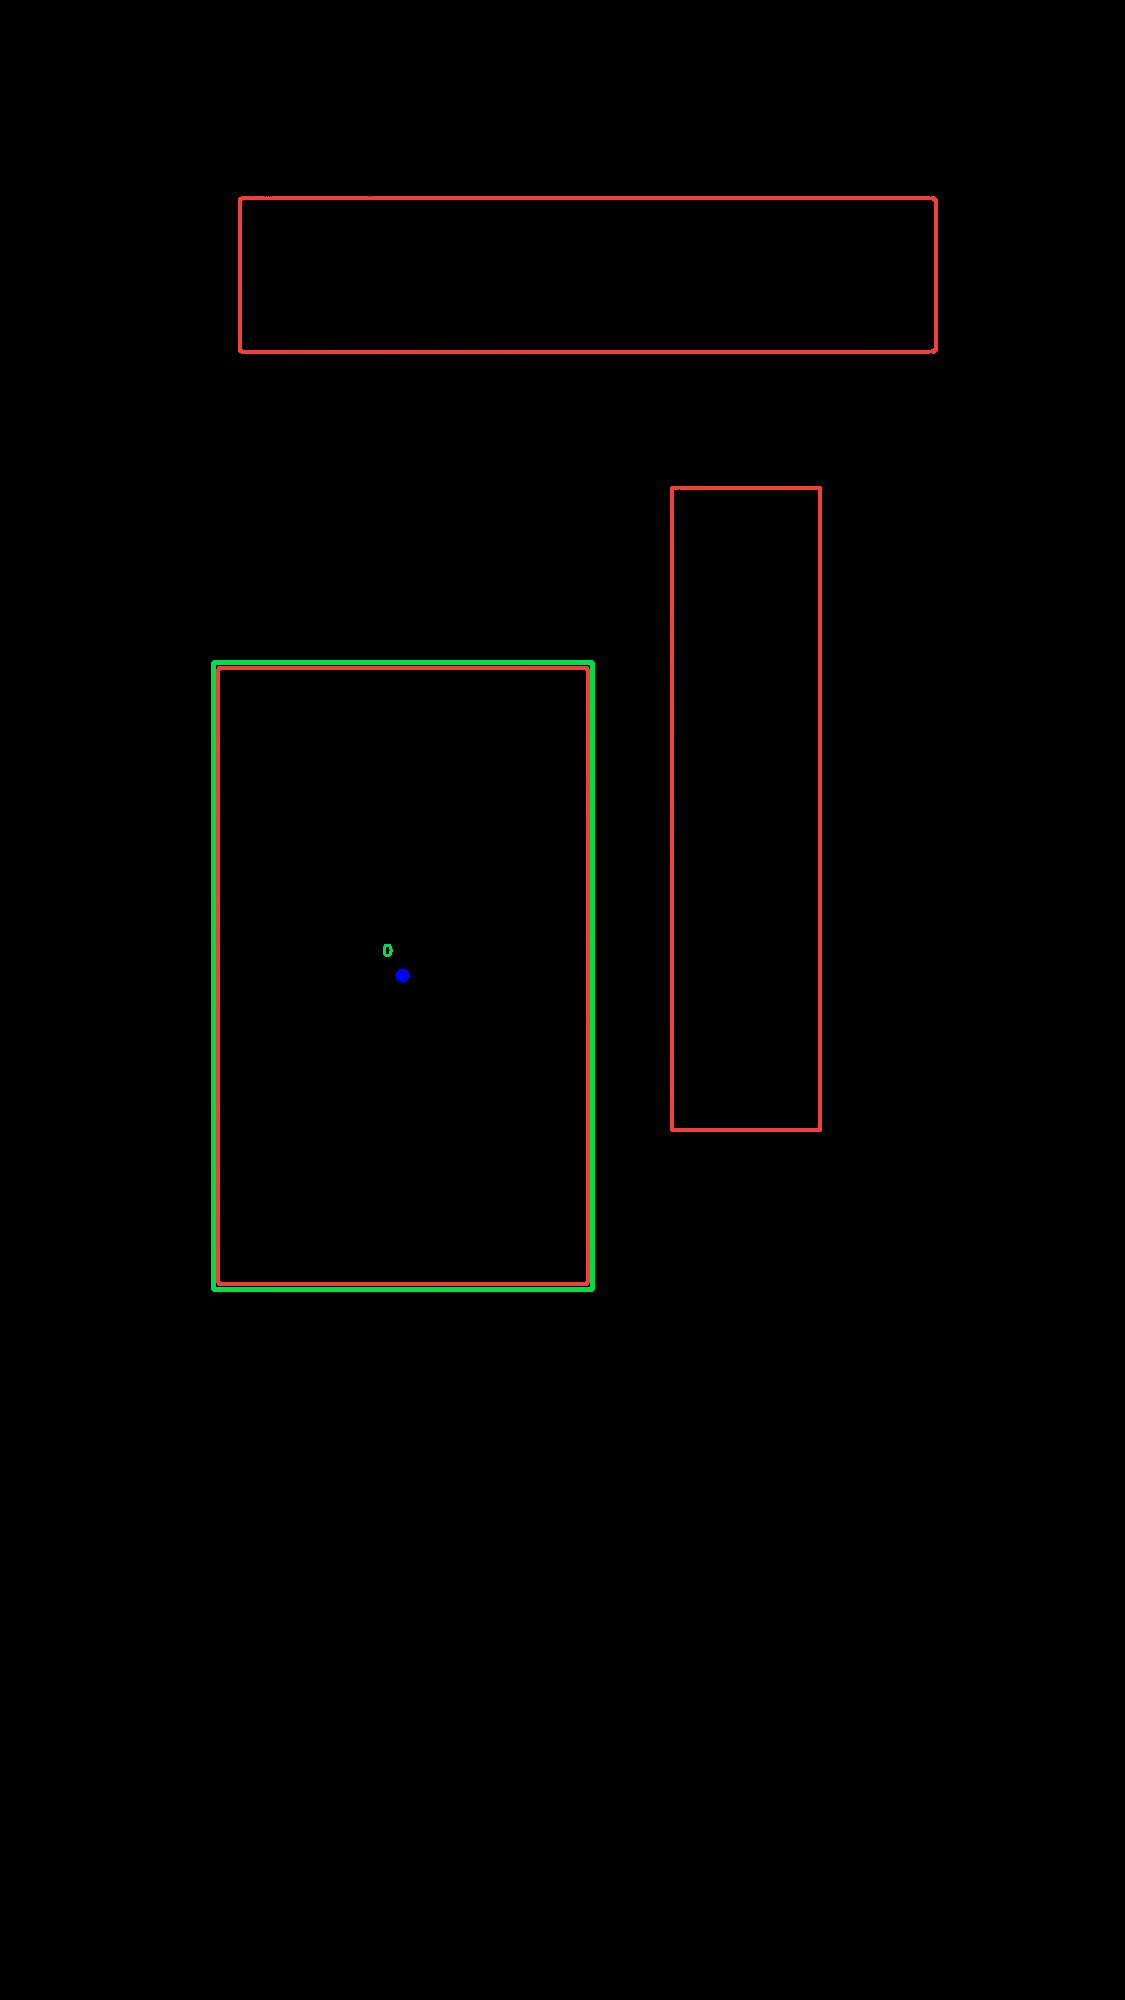

In [35]:
from scipy import misc
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt2d
import random



image = cv2.bilateralFilter(maschera, 15, 80, 80,None)
#cv2_imshow(image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


#cv2_imshow(gray)


thr1=50
thr2=200


kernel = np.ones((5,5 ),np.float32)/49


gray = cv2.dilate(gray, kernel, iterations=3)

#cv2_imshow(gray)


gray = cv2.erode(gray, kernel, iterations=1)

#cv2_imshow(gray)



edged = cv2.Canny(gray, thr1, thr2)
#cv2_imshow(edged)

kernel = np.ones((3,3), np.uint8)


contours, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



#print("Number contorni trovati = " + str(len(contours)))


cntFound = 0
finalCnt = []
cnt=contours[0]
area = cv2.contourArea(cnt)
#print("area",area)

    # Vado a selezionare uno dei pezzi riconosciuti
if area > 100:


        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)

        #Vado a determinare per il box trovato la posizione del vertice più in alto a sx
        min=100000
        i=0
        pos=0
        somma=0
        for riga in approx:
          for elemento in riga:
            somma=elemento[1]+elemento[0]
            if somma<min:
              min=somma
              min1=elemento[0]
              min2=elemento[1]
              pos=i
            i=i+1
        #print(pos)

        #Vado a determinare per il box trovato la posizione del vertice più in basso a dx
        max=0
        j=0
        pos2=0
        somma=0
        for riga in approx:
          for elemento in riga:
            somma=elemento[1]+elemento[0]
            if somma>max:
              max=somma
              max1=elemento[0]
              max2=elemento[1]
              pos2=j
            j=j+1
        #print(pos2)
        #print(somma)


        #print(piccoloy)
        #Trovo il centro della figura dove andare a portare la pinza del robot
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(image, (cX, cY), 7, (255, 0, 0), thickness=-1)
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(image, [approx], -1, (r, g, b), 3)
        cv2.putText(image, str(cntFound), (cX - 20, cY - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (r, g, b), 2)
        cntFound = 1 + cntFound
        finalCnt.append(cnt)


cv2_imshow(image)



In [13]:
import cv2
from PIL import Image

Ritaglio l'immagine facendo un operazione di "crop" con le coordinate recuperate prima

In [14]:
immagine =cv2.imread('/content/original.jpeg')
immagine_rgb = cv2.cvtColor(immagine, cv2.COLOR_BGR2RGB)
immagine_pillow = Image.fromarray(immagine_rgb)
pixel_top_sinistra = [min1, min2]  # Esempio di coordinate in pixel
pixel_bottom_destra = [max1, max2]
top = pixel_top_sinistra[1]
left = pixel_top_sinistra[0]
bottom = pixel_bottom_destra[1]
right = pixel_bottom_destra[0]
immagine_ritagliata = immagine_pillow.crop((left, top, right, bottom))
immagine_ritagliata_opencv = np.array(immagine_ritagliata)
cv2.imwrite('/content/immagine_ritagliata.jpg', immagine_ritagliata_opencv)


True

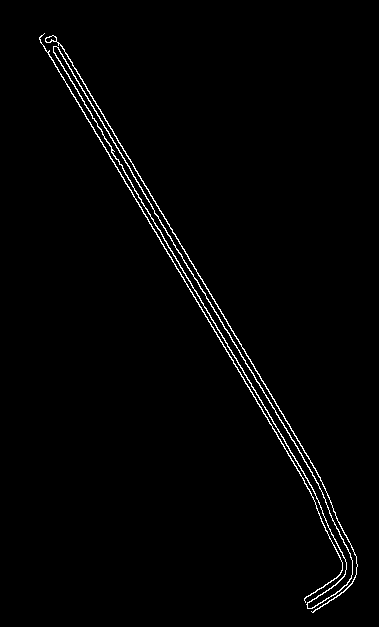

In [15]:
#Test per capire le varie aree nel pezzo una volta applicata la funzione di cannyedge
immagine =cv2.imread('/content/immagine_ritagliata.jpg')
gray = cv2.cvtColor(immagine, cv2.COLOR_BGR2GRAY)

kernel = np.ones((3,3), np.uint8)
dilata = cv2.dilate(gray, kernel, iterations=1)
edged2 = cv2.Canny(dilata, 120, 220)
cv2_imshow(edged2)

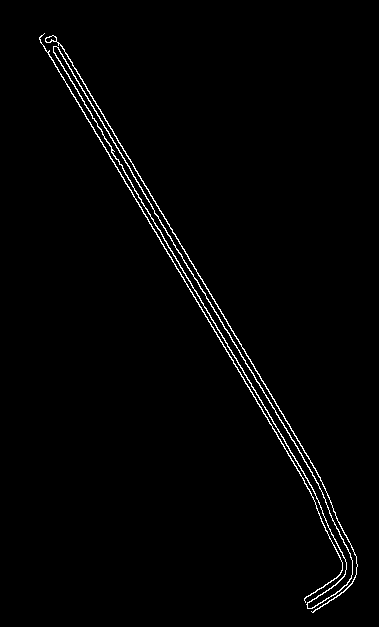

area 4502.5
-151
area 366.5
-151
area 307.5
-150


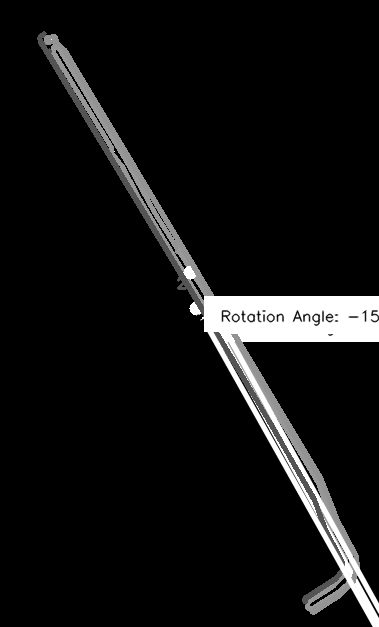

In [39]:
import cv2
import numpy as np
from scipy import misc
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt2d
import random



image = cv2.bilateralFilter(edged2, 15, 80, 80,None)

gray=edged2

cv2_imshow(gray)

contours, hierarchy = cv2.findContours(edged2,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)





cntFound = 0
finalCnt = []
arearif=0
angolorif=0
for cnt in contours:
 area = cv2.contourArea(cnt)
 print("area",area)

 #Cerco l'area più grande per poi andarne a determinare l'orientamento
 if area > 40:


        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)

        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        cv2.circle(image, (cX, cY), 7, (255, 0, 0), thickness=-1)

        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(image, [approx], -1, (r, g, b), 3)
        cv2.putText(image, str(cntFound), (cX - 20, cY - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (r, g, b), 2)
        angolo=getOrientation(cnt, image)
        if area > arearif:
          arearif=area
          angolorif=angolo
          centro1=cX
          centro2=cY
        print(-int(np.rad2deg(angolo)) - 90)
        cntFound = 1 + cntFound
        finalCnt.append(cnt)


cv2_imshow(image)


Rotazione del pezzo in posizione verticale

In [38]:
immagine = cv2.imread('/content/immagine_ritagliata.jpg')
#Aggiungo un padding per evitare di tagliare parti importanti dell'immainge durante la rotazione
valore_padding = 250
immagine_rgb = cv2.cvtColor(immagine, cv2.COLOR_BGR2RGB)
immagine_pillow = Image.fromarray(immagine_rgb)

width, height = immagine_pillow.size
immagine_con_padding = Image.new('RGB', (width + 2 * valore_padding, height + 2 * valore_padding), (118, 170, 122))  # Colore di sfondo bianco (RGB 255, 255, 255)
immagine_con_padding.paste(immagine_pillow, (valore_padding, valore_padding))

#Ruoto l'immagine in base all'angolo trovato prima
centro = (immagine_con_padding.width // 2, immagine_con_padding.height // 2)
angolo_rotazione = int(np.rad2deg(angolorif)) - 90
M = cv2.getRotationMatrix2D(centro, angolo_rotazione, 1.0)
immagine_ruotata = cv2.warpAffine(np.array(immagine_con_padding), M, (immagine_con_padding.width, immagine_con_padding.height))




# Salvare l'immagine ruotata
cv2.imwrite('/content/immagine_ruotata.jpg', immagine_ruotata)

True

Miglioro aree immagine

In [18]:
image = cv2.imread('/content/immagine_ruotata.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((5, 5), dtype=np.uint8)
kernel2 = np.ones((2, 2), dtype=np.uint8)
dilated_image = cv2.dilate(gray_image, kernel)
erosa = cv2.erode(dilated_image, kernel2, iterations=1)

# Save the dilated image
cv2.imwrite('/content/dilated.jpg', erosa)


True

Vado a centrare meglio il pezzo che potrebbe essersi spostato dall'asse centrale dopo il padding

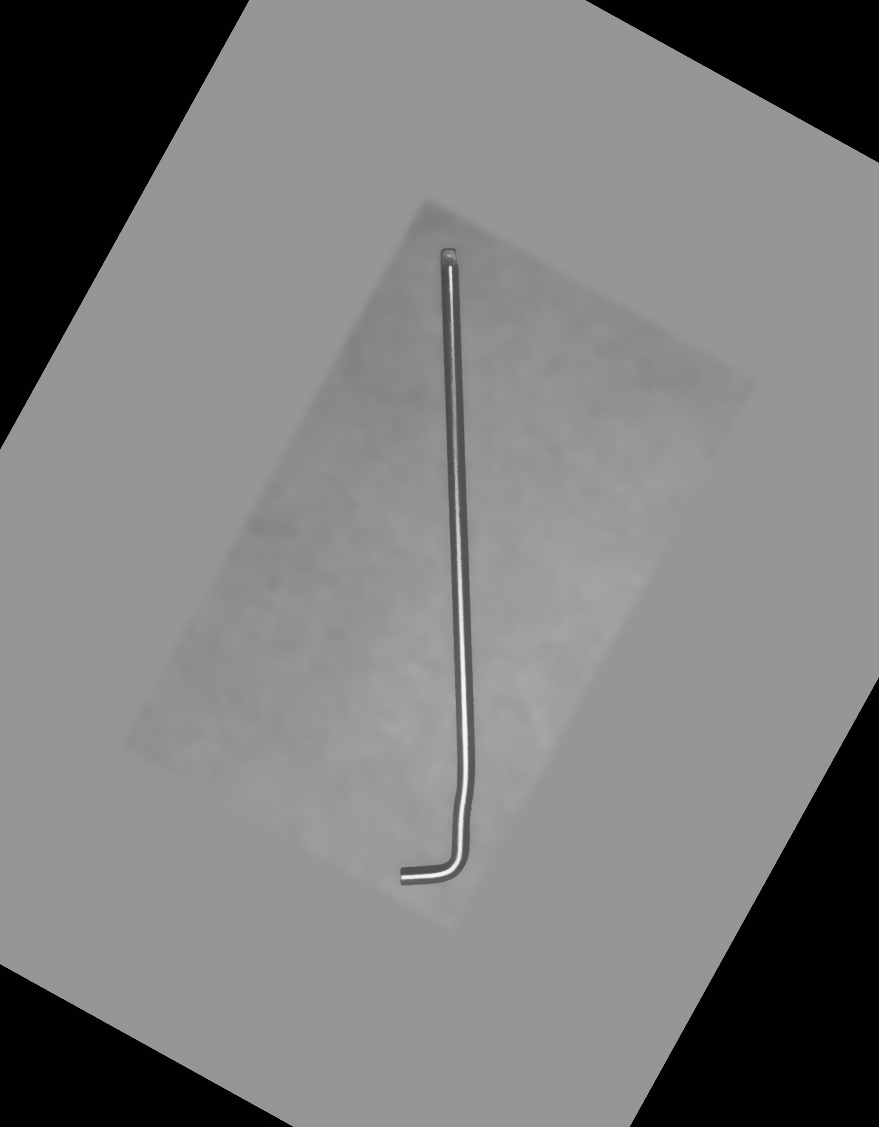

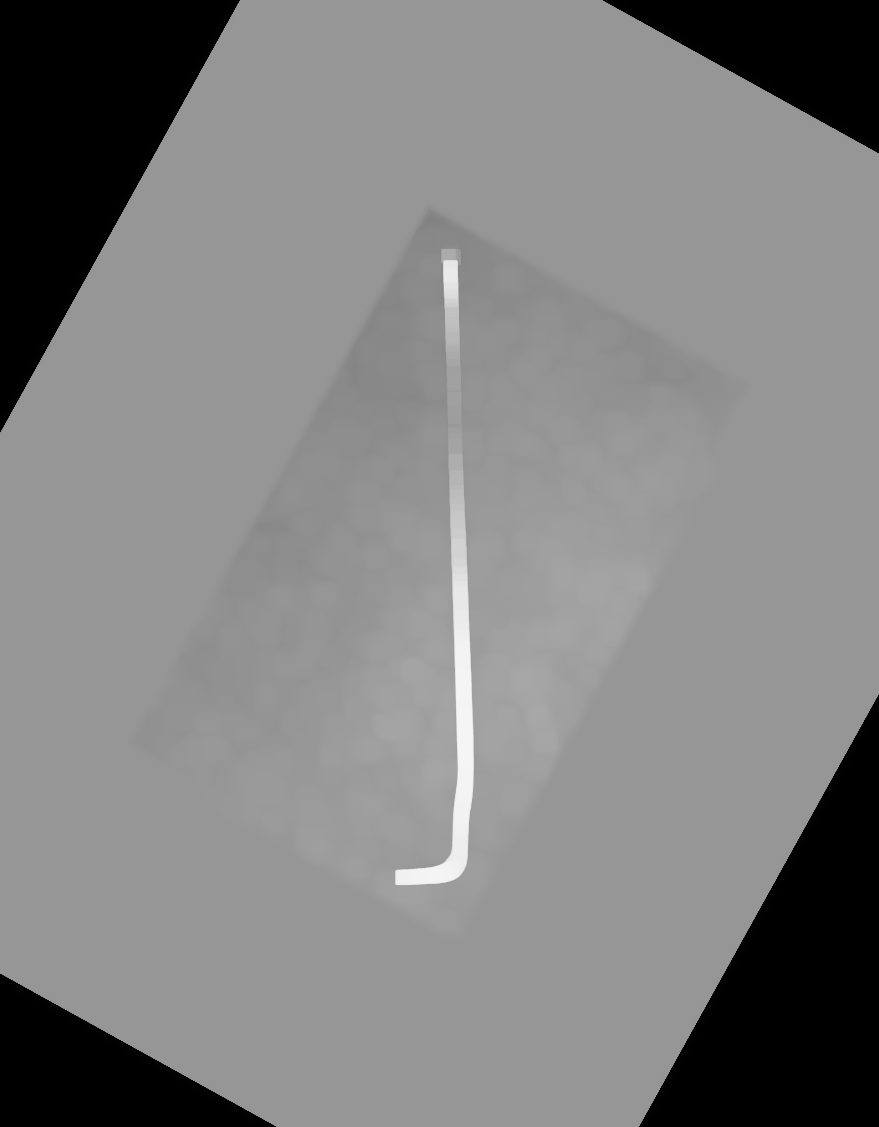

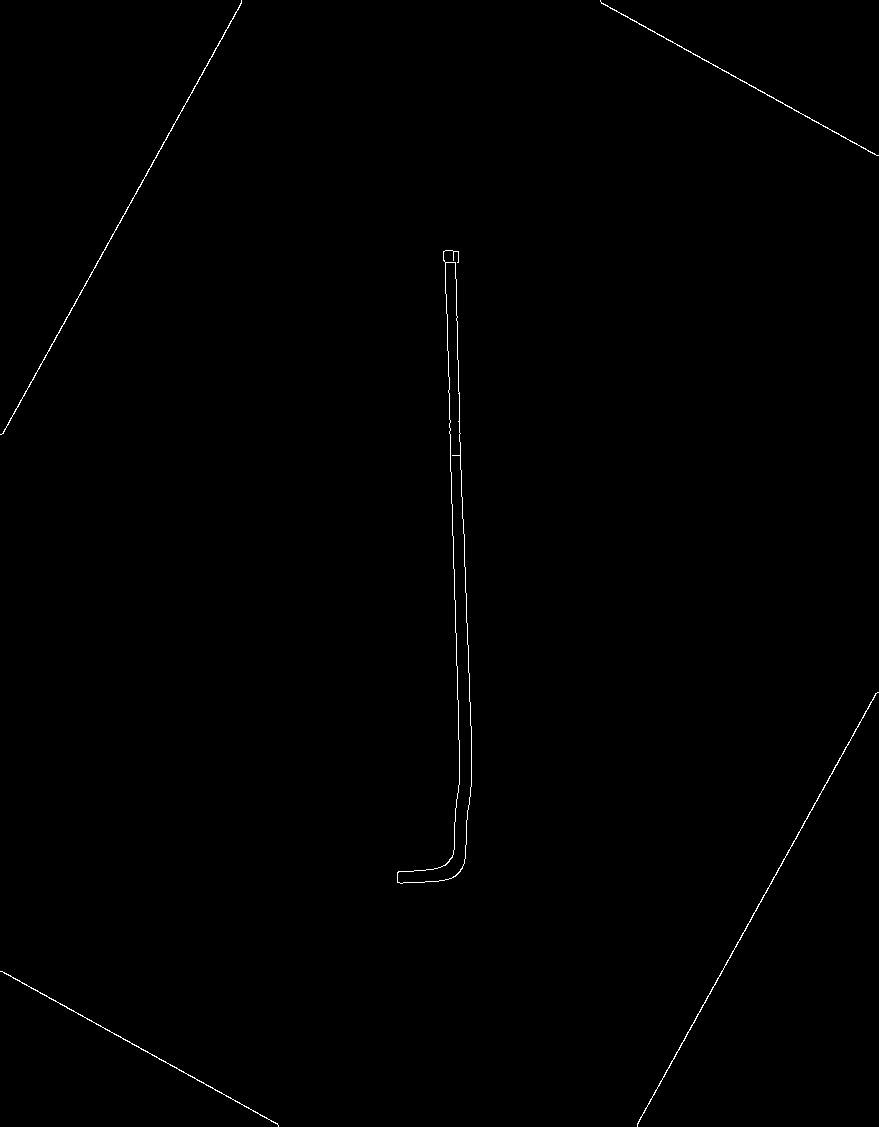

area 108.5
-119
area 176.5
-208
area 7415.0
-180
area 111.5
-119
area 173.5
-208


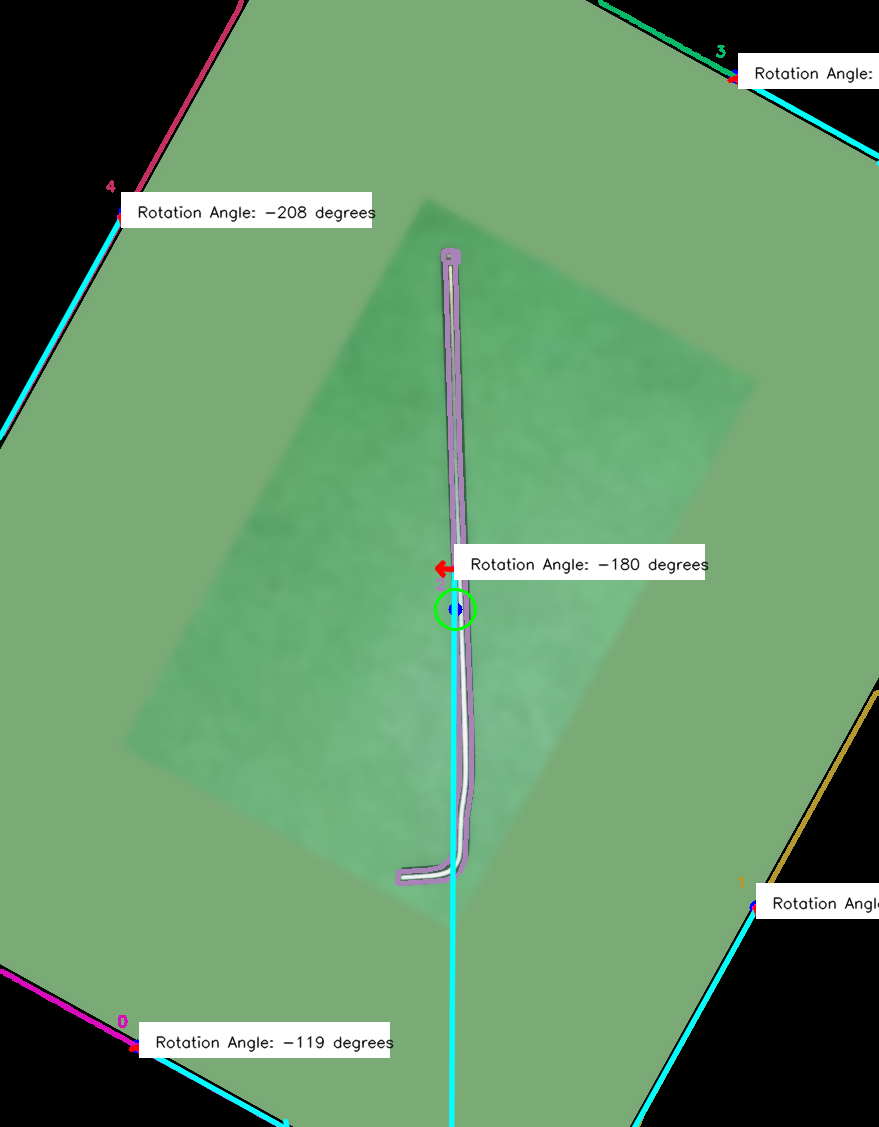

In [40]:
image = cv2.imread('/content/immagine_ruotata.jpg')

image = cv2.bilateralFilter(image, 15, 80, 80,None)


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray)

thr1=20
thr2=120


kernel = np.ones((5,5 ),np.float32)/49

gray = cv2.dilate(gray, kernel, iterations=3)

cv2_imshow(gray)

gray = cv2.erode(gray, kernel, iterations=1)

edged = cv2.Canny(gray, thr1, thr2)
cv2_imshow(edged)

kernel = np.ones((3,3), np.uint8)


contours2, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



cntFound = 0
finalCnt = []
arearif=0
angolorif=0
for cnt in contours2:
 area = cv2.contourArea(cnt)
 print("area",area)

 #Cerco pure qui l'area più grande
 if area > 40:


        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)

        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        cv2.circle(image, (cX, cY), 7, (255, 0, 0), thickness=-1)

        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(image, [approx], -1, (r, g, b), 3)
        cv2.putText(image, str(cntFound), (cX - 20, cY - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (r, g, b), 2)
        angolo=getOrientation(cnt, image)
        if area > arearif:
          arearif=area
          angolorif=angolo
          centro1=cX
          centro2=cY
        print(-int(np.rad2deg(angolo)) - 90)
        cntFound = 1 + cntFound
        finalCnt.append(cnt)

#Cerco di capire il centro del pezzo in modo da poterlo spostare al centro dell'immagine
#print(centro1)
#print(centro2)

centro = (centro1, centro2)  # Sostituisci con le tue coordinate (x, y)
raggio = 20  # Regolare il raggio del cerchio

# Colore del cerchio (BGR)
colore_cerchio = (0, 255, 0)  # Verde (modifica come preferisci)

# Spessore del bordo del cerchio (in pixel)
spessore_linea = 2

# Disegnare il cerchio
cv2.circle(image, centro, raggio, colore_cerchio, spessore_linea)

# Visualizzare l'immagine con il cerchio
cv2_imshow(image)


Disegno linea

Sposto il pezzo al centro dell'immagine

In [20]:

punto_riferimento = (centro1, centro2)
image = Image.open('/content/immagine_ruotata.jpg')
# Calcolare lo spostamento
centro_immagine = (image.width // 2, image.height // 2)
spostamento = (centro_immagine[0] - punto_riferimento[0], centro_immagine[1] - punto_riferimento[1])
print(centro_immagine)
# Spostare l'immagine
immagine_spostata = image.transform((image.width, image.height), Image.AFFINE, (1, 0, -spostamento[0], 0, 1, spostamento[1]+50))

# Salvare l'immagine modificata
immagine_spostata.save('immagine_spostata.jpg')

(439, 563)


Parte per capire se immagine sia stata centrata ed il contenuto dei 4 quadranti

In [21]:
from PIL import ImageDraw
#immagine = cv2.imread('/content/immagine_ruotata.jpg')
immagine = cv2.imread('/content/immagine_spostata.jpg')
immagine_rgb = cv2.cvtColor(immagine, cv2.COLOR_BGR2RGB)
immagine_pillow = Image.fromarray(immagine_rgb)
width, height = immagine_pillow.size
centro_x = width // 2
centro_y = height // 2
colore_linea = (255, 0, 0)  # Colore rosso (RGB)
draw = ImageDraw.Draw(immagine_pillow)
#draw.line((0, centro_y, width, centro_y), fill=colore_linea, width=10)  # Spessore linea 5
#draw.line((centro_x, 0, centro_x, height), fill=colore_linea, width=10)
immagine_opencv = np.array(immagine_pillow)
cv2.imwrite('/content/immagine_con_linee_opencv.jpg', immagine_opencv)  # Salvare l'immagine OpenCV con le linee (facoltativo)


True

In [42]:
from PIL import Image


immagine_originale = Image.open('/content/immagine_con_linee_opencv.jpg')


altezza_da_ritagliare = 100  # Ritaglio i primi 100 pixel dall'alto


larghezza, altezza = immagine_originale.size
#print(altezza,larghezza)
altezza_da_ritagliare = altezza/2

# Creo un nuovo rettangolo con le coordinate dell'area da ritagliare
riquadro = (0, 0, larghezza, altezza_da_ritagliare)

# Ritaglio l'immagine
immagine_ritagliata = immagine_originale.crop(riquadro)


immagine_ritagliata.save("/content/immagine_ritagliata2.jpg")

Ritaglio conenuto quadrante alto a dx

In [43]:
from PIL import Image


immagine_originale = Image.open("/content/immagine_con_linee_opencv.jpg")


altezza_da_ritagliare = 100  # Ritaglio i primi 100 pixel dall'alto

# Ottieni le dimensioni dell'immagine
larghezza, altezza = immagine_originale.size
larghezza_da_ritagliare = larghezza/2
#print(larghezza_da_ritagliare)

# Creo un nuovo rettangolo con le coordinate dell'area da ritagliare
riquadro = (larghezza_da_ritagliare+10, altezza*1/8, larghezza*5/7, altezza*3/7)

# Ritaglio l'immagine
immagine_ritagliata = immagine_originale.crop(riquadro)


immagine_ritagliata.save("/content/immagine_ritagliata_alto_dx.jpg")

Ritaglio contenuto quadrante in basso a sx

In [25]:
immagine_originale = Image.open("immagine_con_linee_opencv.jpg")


altezza_da_ritagliare = 100  # Ritaglia i primi 100 pixel dall'alto

# Ottieni le dimensioni dell'immagine
larghezza, altezza = immagine_originale.size


# Creo un nuovo rettangolo con le coordinate dell'area da ritagliare
riquadro = (larghezza*2/5, altezza*5/7, larghezza/2+5, altezza*6/7)

# Ritaglio l'immagine
immagine_ritagliata = immagine_originale.crop(riquadro)

immagine_ritagliata.save("immagine_ritagliata_basso_sx.jpg")

Analizzo contenuto quadrante in basso a sx

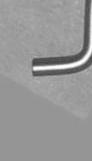

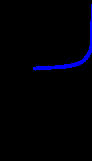

True

In [26]:
import cv2


immagine = cv2.imread('immagine_ritagliata_basso_sx.jpg')

immagine_grigia = cv2.cvtColor(immagine, cv2.COLOR_BGR2GRAY)
cv2_imshow(immagine_grigia)

# Creo una maschera per il bianco in modo da evidenziare la parte lucida del pezzo
maschera_bianco = cv2.inRange(immagine_grigia, 180, 255)

#Trasformo il bianco in blu
immagine_blu = np.zeros_like(immagine)
immagine_blu[:, :, 0] = 255
immagine_blu[:, :, 1] = 0
immagine_blu[:, :, 2] = 0

# Combina l'immagine blu con la maschera per il bianco
immagine_finale = cv2.bitwise_and(immagine_blu, immagine_blu, mask=maschera_bianco)

# Immagine finale
cv2_imshow(immagine_finale)
cv2.waitKey(0)

cv2.imwrite('immagine_blu1.jpg', immagine_finale)


Funzione per migliorare l'identificazione dell'area tramite aggiunta di piccola linea nera

In [27]:
def disegna_linea_verticale_nera(immagine,sel):

  spessore=1
  altezza, larghezza, canali = immagine.shape
  posizione_linea=0

  nero = (0, 0, 0)

  # 1 se linea a destra, altrimenti viene messa a sinistra dell'immagine
  if sel==1:
   posizione_linea = larghezza - spessore
  else:
   posizione_linea = 0
   larghezza=1

  # Disegna la linea verticale nera
  for y in range(altezza):
    for x in range(posizione_linea, larghezza):
      immagine[y, x] = nero

  return immagine

Verifico la presenza della parte superiore del pezzo nel quadrante in basso a sx

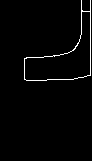

area 2046.0
destra identificata


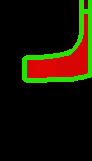

In [44]:
image = cv2.imread('immagine_blu1.jpg')

image = cv2.bilateralFilter(image, 15, 80, 80,None)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


thr1=100
thr2=220


kernel = np.ones((20,20 ),np.float32)

gray = cv2.dilate(gray, kernel, iterations=1)


immagine_con_linea = disegna_linea_verticale_nera(gray,1)
edged = cv2.Canny(gray, thr1, thr2)
cv2_imshow(edged)
cv2.waitKey(0)

contours, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)






cntFound = 0
finalCnt = []
areamax=0
for cnt in contours:
  area = cv2.contourArea(cnt)
  print("area",area)
  #Cerco ancora l'area più grande tra quelle trovate
  if area >= 300:

        if areamax<area:
          areamax=area
        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)



        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(gray, [approx], -1, (r, g, b), 3)

        cntFound = 1 + cntFound
        finalCnt.append(cnt)



id=1
if areamax<700:
 id=0
else:
  print("destra identificata")
cv2_imshow(gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

Analizzo contenuto quadrante alto a dx

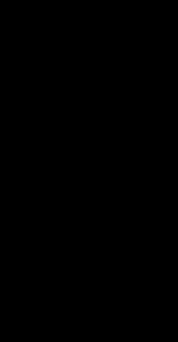

True

In [29]:
import cv2


immagine = cv2.imread('immagine_ritagliata_alto_dx.jpg')


immagine_grigia = cv2.cvtColor(immagine, cv2.COLOR_BGR2GRAY)

# Creo una maschera per il bianco
maschera_bianco = cv2.inRange(immagine_grigia, 180, 255)

#Maschera blu
immagine_blu = np.zeros_like(immagine)
immagine_blu[:, :, 0] = 255
immagine_blu[:, :, 1] = 0
immagine_blu[:, :, 2] = 0

# Combino l'immagine blu con la maschera per il bianco
immagine_finale = cv2.bitwise_and(immagine_blu, immagine_blu, mask=maschera_bianco)

# Immagine finale
cv2_imshow(immagine_finale)
cv2.waitKey(0)


cv2.imwrite('immagine_blu.jpg', immagine_finale)

Verifico presenza parte superiore pezzo in quadrante alto a dx

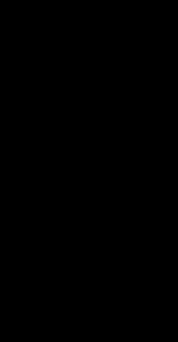

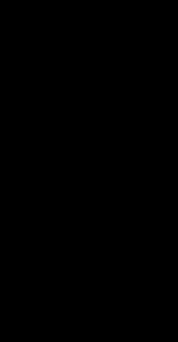

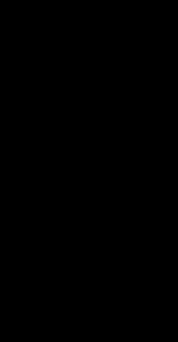

In [30]:
image = cv2.imread('immagine_blu.jpg')

image = cv2.bilateralFilter(image, 15, 80, 80,None)

cv2.waitKey(0)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)




cv2.waitKey(0)

thr1=100
thr2=220


kernel = np.ones((30,30 ),np.float32)


cv2_imshow(gray)
cv2.waitKey(0)

gray = cv2.dilate(gray, kernel, iterations=1)



cv2.waitKey(0)

immagine_con_linea = disegna_linea_verticale_nera(gray,2)
edged = cv2.Canny(gray, thr1, thr2)
cv2_imshow(edged)
cv2.waitKey(0)



contours, hierarchy = cv2.findContours(edged,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)





cntFound = 0
finalCnt = []
areamax=0
for cnt in contours:
  area = cv2.contourArea(cnt)
  print("area",area)

   #Cerco area più grande
  if area >= 10:

        if areamax<area:
          areamax=area
        approx = cv2.approxPolyDP(cnt,0.001 * cv2.arcLength(cnt, True), True)
        #print(approx)


        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        cv2.drawContours(gray, [approx], -1, (r, g, b), 3)

        cntFound = 1 + cntFound
        finalCnt.append(cnt)
id2=1

if areamax<700:
  id2=0
else:
  print("destra identificata")
cv2_imshow(gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

Dato il pezzo buono identificato tramite YOLO se non trovo la parte superiore del pezzo nei quadranti alto a dx o basso a sx allora sono sicuro che il pezzo sia sinistro, altrrimenti sarà destro.

In [31]:
if id==0 and id2==0:
  print("Il pezzo è sinistro")
else:
  print("il pezzo è destro")

il pezzo è destro
